In [10]:
import os
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt

In [ ]:
# HYPERPARAMETERS
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 51
NOISE_SIZE = 100

Part 1: Create Grumpy Cat Dataset

In [12]:
class CustomDataset(Dataset):
    def __init__(self, dir, transform = transforms.ToTensor()):
        self.total_imgs: list[torch.Tensor] = []
        for file in os.listdir(dir):
            self.total_imgs.append( Image.open(dir + '/' + file) )
        self.transform = transform
    
    def __len__(self) -> int:
        return len(self.total_imgs)
    
    def __getitem__(self, idx) -> Image.Image:
        return self.transform(self.total_imgs[idx])

Part 2: Data Augmentation

In [13]:
def get_transform(mode: str) -> nn.Module:
    if mode == "simple":
        return transforms.Compose([
            transforms.Resize((64, 64), transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    elif mode == "deluxe":
        return transforms.Compose([
            transforms.Resize((64, 64), transforms.InterpolationMode.BICUBIC),
            transforms.RandomGrayscale(0.2),
            transforms.RandomRotation(180),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    raise NotImplementedError

Part 3: Implement the Discriminator of the DCGAN

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # size_out = (size_in + 2 * padding - kernel) / stride + 1
        self.layers = nn.Sequential(
            # INPUT 3x64x64
            nn.Conv2d(  3,  32, kernel_size=4, stride=2, padding=1, bias=False), # 32x32x32
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d( 32,  64, kernel_size=4, stride=2, padding=1, bias=False), # 64x16x16
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d( 64, 128, kernel_size=4, stride=2, padding=1, bias=False), # 128x8x8
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # 256x4x4
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=6, stride=2, padding=1, bias=False)    # 1x1x1
        )
    
    def forward(self, z) -> torch.Tensor:
        return self.layers(z).squeeze()

Part 4: Implement the Generator of the DCGAN

In [15]:
class Generator(nn.Module):
    def __init__(self, noise_size=100):
        super(Generator, self).__init__()
        # size_out = (size_in - 1) * stride - 2 * padding + kernel
        self.layers = nn.Sequential(
            # INPUT nsx1x1
            nn.ConvTranspose2d(noise_size, 256, kernel_size=6, stride=2, padding=1, bias=False),    # 256x4x4
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),           # 128x8x8
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),            # 64x16x16
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.ConvTranspose2d( 64, 32, kernel_size=4, stride=2, padding=1, bias=False),            # 32x32x32
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.ConvTranspose2d( 32,  3, kernel_size=4, stride=2, padding=1, bias=False),            # 3x64x64
            nn.Tanh(),
        )
    
    def forward(self, z) -> torch.Tensor:
        return self.layers(z)

Part 5: Training Loop

In [16]:
def training_loop(dataset: Dataset, prefix: str = "model"):
    # Create generators and discriminators
    generator = Generator(NOISE_SIZE)
    discriminator = Discriminator()

    # Create optimizers for the generators and discriminators
    g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
    D_losses = []
    G_losses = []
    
    iteration = 0 
    for _ in range(NUM_EPOCHS):
        total_loss = [0,0] # total discriminator and generator loss of current epoch
        for data in dataloader:
            n = data.shape[0] # size of current batch
            # 
            # TRAIN DISCRIMINATOR
            # 
            
            d_optimizer.zero_grad()

            # 1. Compute the discriminator loss on real images
            D_real_pred: torch.Tensor = discriminator(data)
            D_real_loss: torch.Tensor = (1 - D_real_pred).pow(2)

            # 2. Sample noise
            noise: torch.Tensor = torch.rand((n,NOISE_SIZE,1,1))

            # 3. Generate fake images from the noise
            fake_images: torch.Tensor = generator(noise)

            # 4. Compute the discriminator loss on the fake images
            D_fake_pred: torch.Tensor = discriminator(fake_images)
            D_fake_loss: torch.Tensor = (-1 - D_fake_pred).pow(2)

            # 5. Compute total loss
            D_total_loss: torch.Tensor = (D_real_loss + D_fake_loss).sum().div(n)
            if iteration % 2 == 0:
                D_total_loss.backward()
                d_optimizer.step()

            # 
            # TRAIN GENERATOR
            # 

            g_optimizer.zero_grad()

            # 1. Sample noise
            noise: torch.Tensor = torch.rand((n,NOISE_SIZE,1,1))

            # 2. Generate fake images from the noise
            fake_images: torch.Tensor = generator(noise)

            # 3. Compute the generator loss
            D_gen_pred: torch.Tensor = discriminator(fake_images)
            G_loss: torch.Tensor = (1 - D_gen_pred).pow(2).sum().div(n)

            G_loss.backward()
            g_optimizer.step()

            # Save model every 200 iterations
            if iteration % 200 == 0:
                torch.save(discriminator.state_dict(), f"models/{prefix}-discriminator-{iteration}.pth")
                torch.save(generator.state_dict(), f"models/{prefix}-generator-{iteration}.pth")
            iteration += 1

            # Add to total loss for epoch
            total_loss[0] += D_total_loss.item()
            total_loss[1] += G_loss.item()
        
        # Record epoch loss for matplot
        D_losses.append(total_loss[0])
        G_losses.append(total_loss[1])
    
    torch.save(discriminator.state_dict(), f"models/{prefix}-discriminator-final.pth")
    torch.save(generator.state_dict(), f"models/{prefix}-generator-final.pth")
    return D_losses, G_losses

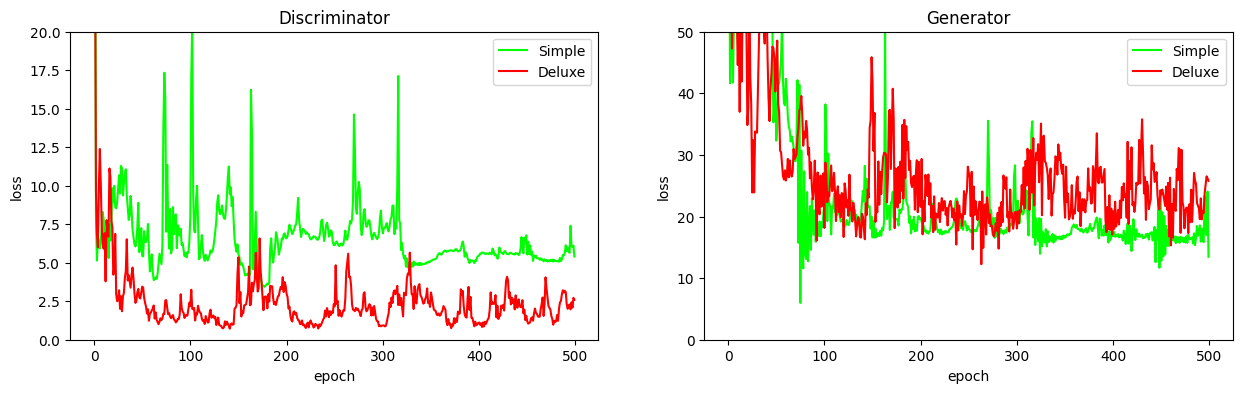

In [17]:
dataset = CustomDataset("grumpifyCat")
# simple transformation
dataset.transform = get_transform("simple")
simple_losses = training_loop(dataset, "s")
# deluxe transformation
dataset.transform = get_transform("deluxe")
deluxe_losses = training_loop(dataset, "d")
# make plot
fig, ax = plt.subplots(1,2,figsize=(15,4))
ax[0].set_title("Discriminator")
ax[0].set(ylim=[0,20])
ax[1].set_title("Generator")
ax[1].set(ylim=[0,50])
for i in [0,1]:
    ax[i].plot(simple_losses[i], label="Simple", c="lime")
    ax[i].plot(deluxe_losses[i], label="Deluxe", c="red")
    ax[i].set(xlabel="epoch", ylabel="loss")
    ax[i].legend()
plt.show()

Set data augmentation mode to deluxe and then show one of the samples from early in
training (e.g., iteration 200) and one of the samples from later in training, and give the
iteration number for those samples.

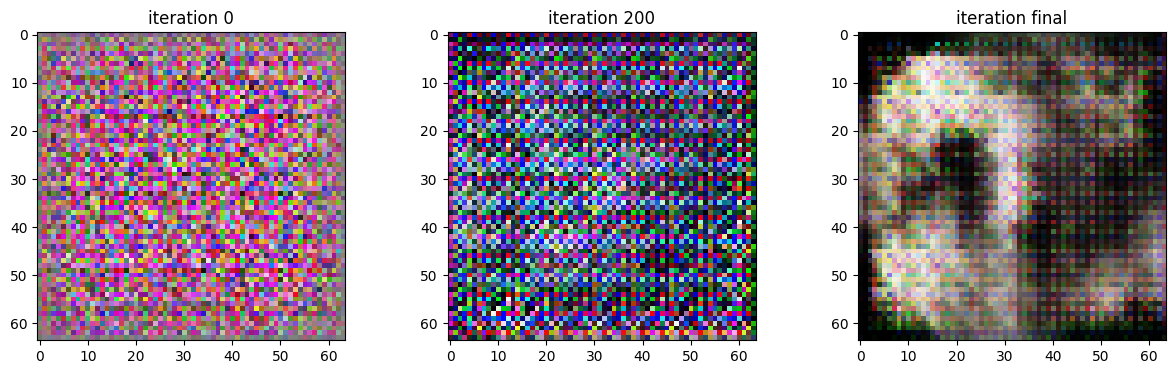

In [18]:
# create a generator and noise
model = Generator(NOISE_SIZE)
noise: torch.Tensor = torch.rand((BATCH_SIZE,NOISE_SIZE,1,1))

fig, ax = plt.subplots(1,3,figsize=(15,4))
with torch.no_grad():
    for i, iteration in enumerate([0,200,"final"]):
        # load model and get an image from it
        model.load_state_dict(torch.load(f"models/d-generator-{iteration}.pth", weights_only=True))
        img = model(noise)[0].permute(1,2,0) # torch image is BSxCxWxH but matplot is WxHxC

        # unnormalize image for viewing purposes
        # torch normalization is out = (in - mean) / std
        #                            = (in - 0.5) / 0.5
        # reversing is   in = out * 0.5 + 0.5
        img = img * 0.5 + 0.5

        # put in plot
        ax[i].set_title(f"iteration {iteration}")
        ax[i].imshow(img)

plt.show()